# Dog Breed Classification

## Introduction

[ImageNet](https://www.image-net.org/) is one of the most popular datasets in computer vision, used mainly for image classification and localisation. Due to its vast size, subsets of this dataset can also be constructed to focus on specific problems. One such dataset is the [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data), containing images of several breeds of dogs, designed for fine-grained image categorisation.

In this assignment, you will be constructing and training neural network-based models to identify the breed of the dog shown in an image. Therefore, the models that will be considered fall under the category of object recognition. Hence, many concepts in related fields (e.g. face recognition) are also applicable here.

**Acknowledgements**

The original data source can be found at http://vision.stanford.edu/aditya86/ImageNetDogs/.

*⚠️ NOTE: The link does not use https to establish a secure connection and thus you may get a security warning if you attempt to access it. Instructions on how to use the dataset will be given below.*

**Reference:**

  Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

**ImageNet Reference:**

  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.

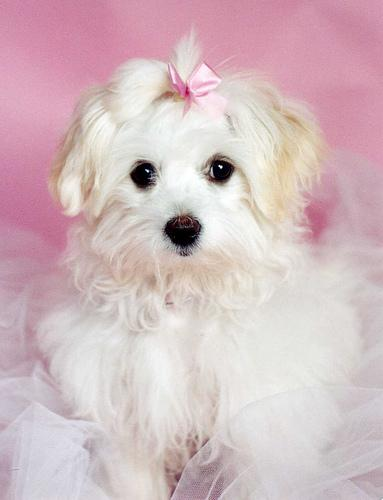

## Instructions
- The dataset is available by accessing the MECC storage (via Networks labs PCs), at `/opt/nfs/shared/images/ImageNetDogs`. The files and folders of interest are as follows:
 - **Images**: Image files
 - **Annotation**: Annotation files, containing metadata such as bounding boxes around the dog in the image
 - **README.txt**: Some information on the dataset

 *⚠️ NOTE: For this assignment, you DO NOT need to use any other files, such as file_list.mat, test_data.mat, etc.*

- This assignment is to be attempted individually.

- All code needs to be developed in Python 3. This Jupyter notebook should be used, and uploaded to the VLE once complete.

- Computers in the Networks lab can be used to train the models required to complete this assignment. It is HIGHLY recommended to use the GPUs.

- Any textual or visual information and equations that might need to be conveyed is expected to be written using the Markdown language.

- The Jupyter notebook to be submitted should be named as follows:

  `name-surname-idnumber.ipynb`

- The list of packages that are allowed for this assignment are as follows: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `xml`, `PIL`, `torchvision` and any other packages agreed with the lecturer.

- If you use any information or material from books, papers, websites, etc., please ensure that the appropriate citations are included.

- The deadline for this assignment is **Friday, 17th January 2025 at 15:00**.

## Package Imports

Import all of the packages required in the notebook

In [1]:
# Os File operations and data processing
import os  
# Random number generation
import random
# XML parsing
import xmltodict 

# Image operations and visualization
from PIL import Image  
import matplotlib.pyplot as plt 

# Data processing and GPU device support
import torch 
# Base class for Neural Network modules
import torch.nn as nn
# Abstract class for the dataset representation
from torch.utils.data import Dataset  
# Makes dataset iterable through sampler 
from torch.utils.data import DataLoader 
# Various optimization algorithms 
import torch.optim as optim  
# Sheduler for adjusting learning rate during training
from torch.optim.lr_scheduler import StepLR 

# Model summary for PyTorch models
from torchsummary import summary 

# Image transformations during the data loading process
from torchvision import transforms 
# Pre-trained models libary (vgg16)
import torchvision.models as torchmodels  

# Visualization of training and evaluation process
from tqdm.notebook import tqdm  

### Device Check

Ensure the remote/local GPU are being used if available and set the device for the whole project use.

In [2]:
# Check if GPU availability and set the device
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

# Check if the device is set correctly
print(f"Device set to: {device}")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


## The Data

### **Q1: Dataset Exploration** ###

Explore the dataset, to determine the characteristics of the data that you're using. Write down any observations.

*ℹ️ NOTE: Feel free to display a few examples, to get an idea of the image characteristics. Observing and understanding the characteristics of a dataset should help you design an effective way to split your data and any precautions or considerations requred when constructing your models (e.g. identifying any issues that may arise, allowing you to take preventative action). Things you could check out include the image quality, resolution, total number of images, number of classes, distribution of the number of images per class, etc.*

**(5 marks)**

Dataset directory structure:
/opt/nfs/shared/images/ImageNetDogs
├── Annotation
├── file_list.mat
├── Images
├── README.txt
├── test_data.mat
├── test_list.mat
├── train_data.mat
└── train_list.mat

2 directories, 6 files

Images folder structure:
/opt/nfs/shared/images/ImageNetDogs/Images/n02085620-Chihuahua:                      directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085782-Japanese_spaniel:               directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085936-Maltese_dog:                    directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086079-Pekinese:                       directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086240-Shih-Tzu:                       directory

Number of Categories:
120

Total number of images:
20580

Observing 4 random images from the dataset:

Image 1 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02088238-basset/n02088238_6708.jpg : (500, 376) pixels

Image 2 resolution:
/opt/nfs/shared/images/ImageNetDo

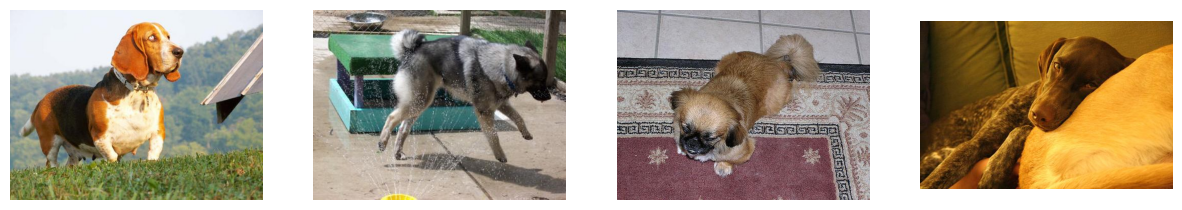

In [3]:
# Define dataset directory
dataset_dir = '/opt/nfs/shared/images/ImageNetDogs'

# List dataset contents
print("Dataset directory structure:")
os.system(f'tree {dataset_dir} -L 1')

"""
Read the README file
print("\nREADME file:")
os.system(f'cat {dataset_dir}/README.txt')
"""

# Check the structure of the Images Folder
print("\nImages folder structure:")
os.system(f'file {dataset_dir}/Images/* | head -n 5')

# Number of Categories
print("\nNumber of Categories:")
os.system(f'ls {dataset_dir}/Images | wc -l')

# Number of total images in Images folder
print("\nTotal number of images:")
os.system(f'find {dataset_dir}/Images -type f | wc -l')

# Declare the number of random images to display
ran_img = 4

# Create subplots
fig, axs = plt.subplots(1, ran_img, figsize=(15, 5))

# Load, display and analyze 4 random images
print("\nObserving " + str(ran_img) +" random images from the dataset:")
for i in range(ran_img):
    img_path = os.popen(f'find {dataset_dir}/Images -type f | shuf -n 1').read().strip()
    img = Image.open(img_path)
    
    # Display image in subplot
    axs[i].imshow(img)
    axs[i].axis('off')
    
    # Check the image resolution
    print("\nImage " + str(i+1) + " resolution:")
    print(f"{img_path} : {img.size} pixels")

# Show all subplots
plt.show()

**A1**:


**Directory Structure and README Analysis**

The dataset directory structure was checked to understand how file access should be done. The README file was read and didn't provide extensive information but led to the data source link of the Stanford Dogs Dataset. More information about the dataset was found there.

**Dataset Overview**

The Images folder contains 120 subfolders, each representing a different dog breed, with a total of 20,580 images in JPEG format and varying resolutions. On average, there are 171 images per category. The Redbone Coonhound has the fewest images (148), while the Maltese Dog has the most (252). Although this range can be seen as relatively significant, the lower end still provides enough images to train a model effectively, making the dataset balanced.Further balancing the dataset by reducing the number of training images would result in a loss of information and increase the risk of overfitting. Therefore, the dataset was not altered with respect to the number of images per category.

**Image Format and Quality Analysis**

The random images displayed and analyzed had different resolutions and sizes. This means that images must undergo preprocessing before being fed into the model. The images will be resized to a standard pixel size and normalized to ensure pixel values all fall within the same range.

A common quality index of 75 was identified across the dataset images.

No corrupted images were found in the dataset.

**Duplicate Images**

Duplicates were found in the dataset, either within the same class or across different classes. Duplicates within the same class do not significantly impact the training process, as they essentially reinforce the same class. Duplicates across classes could represent crossbreeds, where one dog has features of two different breeds. So the dog rightfully belongs to both classes and they were retained in the dataset and not removed.

**Bounding Box Information**

The bounding box folder (Annotation) followed the same folder structure as the Images folder, with XML files instead of JPEG images. The XML files contained the location of the dog in the image. This information could be useful when wanting to extract and load only the dog from the image.


### **Q2: Splitting the dataset** ###
Implement code to split the dataset in such a way as to enable training and testing of a machine learning model.

**(5 marks)**

In [4]:
def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, num_classes=None, seed=None):

    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    # Otherwise, set a random seed
    else:
        random.seed()

    # Get the sorted list of classifications
    classes = sorted(os.listdir(data_dir))

    # Check if a specified number of classes is provided
    if num_classes is not None:
        # Make an upper bound to the number of classes
        classes = classes[:num_classes]

    # Create a dictionary mapping the class breed names to integers
    breed_dict = {breed: i for i, breed in enumerate(classes)}

    # Initialize the 3 splits sets
    train_set = []
    val_set = []
    test_set = []

    # Iterate over the classes
    for breed in classes:
        # Get the list of images for the current class
        img_list = os.listdir(os.path.join(data_dir, breed))
        # Make sure only images are captured (should do nothing)
        img_list = [img for img in img_list if img.endswith('.jpg')]
        
        # Shuffle the list of images
        random.shuffle(img_list)

        # Calculate the split indexes
        num_train = int(len(img_list) * train_ratio)
        num_val = int(len(img_list) * val_ratio)
        
        # Split the images into the 3 sets
        train_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[:num_train]]
        val_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[num_train:num_train + num_val]]
        test_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[num_train + num_val:]]

    # Return the 3 sets and the breed dictionary
    return train_set, val_set, test_set, breed_dict

The split_dataset function is defined to split the dataset into training, validation, and testing sets. The split by default is 70% for training, 15% for validation, and 15% for testing, which is usually a safe split for most datasets allowing mostly training. The validation set is used in the evaluation of the model during training to prevent overfitting, while the testing set will be used at the end to compare the models.

The function also takes in the num_classes parameter which can be used to limit the number of classes to be used in the dataset. This is useful for testing the model on a smaller subset of the dataset. The seed parameter is used to set the random seed for reproducibility. If the seed is not provided, a random seed is set.

The breed_dict is a dictionary that maps the class breed names to integers. This will be needed when it comes to giving the labels to the model during training and evaluation. Since the breeds are strings, they need to be converted to integers for the model to understand them.

The splits are returned as lists of tuples, where each tuple contains the image path and the corresponding breed label. The breed label is a dictionary that maps the breed names to integers.

### **Q3: Custom dataset in PyTorch** ###

A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initialises the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$-th sample.


Write a class `DataLoaderClassification` that can be used to
- Load the list of image filenames and the corresponding lables in two lists in `__init__`
- Load a batch of images and corresponding lables when one calls `__getitem__`
- Returns the length of the dataset using `__len__`

*ℹ️ NOTE: It is recommended to make use of the bounding boxes...*

**(5 marks)**

In [5]:
class DataLoaderClassification(Dataset):
    # Initialization function
    def __init__(self, image_set, breed_dict, transform=None):
        # Initialize the dataset by passing the touple of image path and label, breed dictionary and transformation to be applied
        self.image_set = image_set
        self.breed_dict = breed_dict
        self.transform = transform

    # Length function
    def __len__(self):
        # Simply return the length of the image set
        return len(self.image_set)
    
    # Load idx-th item
    def __getitem__(self, idx):
        # Since the image_set contains tuples of (image_path, label), we can directly access the image path by taking the first element of the tuple
        img_path = self.image_set[idx][0]
        
        # Make sure the image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
    
        # Open the image
        img = Image.open(img_path)
        
        # Get the respective bounding box file path
        bbox_path = img_path.replace('Images', 'Annotation').removesuffix('.jpg') 
        
        # Check if the bounding box file exists
        if not os.path.exists(bbox_path):
            raise FileNotFoundError(f"Bounding box file not found: {bbox_path}")
        
        # Parse the bounding box XML file
        with open(bbox_path) as fd:
            doc = xmltodict.parse(fd.read())
        
        # Handle multiple objects in the annotation
        objects = doc['annotation']['object']
        if isinstance(objects, list):
            bndbox = objects[0]['bndbox']  # Use the first object's bounding box
        else:
            bndbox = objects['bndbox']

        # Set the bounding box coordinates
        xmin = int(bndbox['xmin'])
        ymin = int(bndbox['ymin'])
        xmax = int(bndbox['xmax'])
        ymax = int(bndbox['ymax'])
            
        # Crop the image using the bounding box coordinates
        img = img.crop((xmin, ymin, xmax, ymax))
        
        # Apply transformation if any
        if self.transform:
            img = self.transform(img)
        
        # To get the label, we can simply take the second element of the tuple
        label = self.image_set[idx][1]
        
        # Return the image and the label
        return img, label

The custom dataset builds off of the Dataset class from PyTorch. We define the __init__ function to initialize the dataset with the image set's touple, breed dictionary, and transformation. The __len__ function returns the length of the image set and the __getitem__ function loads the idx-th item from the dataset. We open the image and parse the bounding box XML file to crop the image using the bounding box coordinates. Finally, we apply the transformation and return the processed image and label. Note we must first crop to the image and then apply transformation, as if the order is reversed the bounding box cordinates will not align with that of the transformed image.

### **Q4: PyTorch dataloaders** ###

Write code that creates the PyTorch dataloaders to train and test the model.

**(5 marks)**

In [6]:
# Define the transformation to be applied on the training set.
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert('RGB')),  
    transforms.ToTensor(),
])

# Define the transformation to be applied on the validation set
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert('RGB')), 
    transforms.ToTensor(),
])

# Define the dataset image directory
directory = '/opt/nfs/shared/images/ImageNetDogs/Images'

# Split the dataset using the split_dataset function
train_set, val_set, test_set, breed_dict = split_dataset(directory, train_ratio=0.7, val_ratio=0.15)

# Set the number of classes
num_classes = len(breed_dict)

# Reverse dictionary to map labels to breed names
label_dict = {label: breed for breed, label in breed_dict.items()}

# Initialize the DataLoaderClassification objects for the train, val and test sets
train_loader = DataLoaderClassification(train_set, breed_dict, transform=train_transform)
val_loader = DataLoaderClassification(val_set, breed_dict, transform=val_transform)
test_loader = DataLoaderClassification(test_set, breed_dict, transform=val_transform)

# Define the batch size for the data loaders (how many samples to load at once when loading the data from dataloader)
batch_size = 64

# Use the DataLoader class to create the data loaders for the train, val and test sets based on the DataLoaderClassification objects
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_loader, batch_size=batch_size, shuffle=False)


# Get the total number of samples in the dataset (if all breeds are considered)
total_samples = int(os.popen(f'find {directory} -type f | wc -l').read().strip())
# The number of samples in the training, validation and test sets
train_samples = len(train_loader.dataset)
val_samples = len(val_loader.dataset)
test_samples = len(test_loader.dataset)
print(f"Total samples in the dataset: {total_samples}")
print(f"Samples in the training set: {train_samples}")
print(f"Samples in the validation set: {val_samples}")
print(f"Samples in the test set: {test_samples}")
# Check if the totals match
if total_samples == (train_samples + val_samples + test_samples):
    print("Data split successful")
else:
    print("Data split unsuccessful")
    print(f"Total samples is meant to be {total_samples} but got {train_samples + val_samples + test_samples}")

Total samples in the dataset: 20580
Samples in the training set: 14355
Samples in the validation set: 3025
Samples in the test set: 3200
Data split successful


The training and validation data transformations were defined separately to allow for additional data augmentation if needed for the training set. However, during testing, the model performed well on the training set but poorly on the validation set when extra augmentation was applied. This meant that the model was overfitting on the training set. So less aggressive augmentation was applied but the same characteristics were noted. So a common base transformation was used for both sets. Here, the images were resized to a standard size of 128x128, converted to RGB, and converted to a tensor. The images are firsts resized and converted to RGB before being converted to a tensor as it is easier and less computationally expensive in PIL format. No normalization was applied as the image quality was consistent and the model performed well without it.

The image directory was defined, and the dataset was split into training, validation, and test sets with default ratios of 70%, 15%, and 15%, respectively. The number of classes (all 120) was tracked, and a reverse dictionary was created to map labels to breed names.

The DataLoaderClassification class was initialized for the train, validation, and test sets. The batch size was set to 64, which is a common value for training deep learning models, allowing for efficient use of the GPU and its memory. The DataLoader class was used to create the data loaders for the train, validation, and test sets based on the DataLoaderClassification objects. The data loaders were shuffled for the training set to ensure that the model generalizes well and is not biased by the order of the samples. The validation and test sets were not shuffled to maintain the order of the samples.

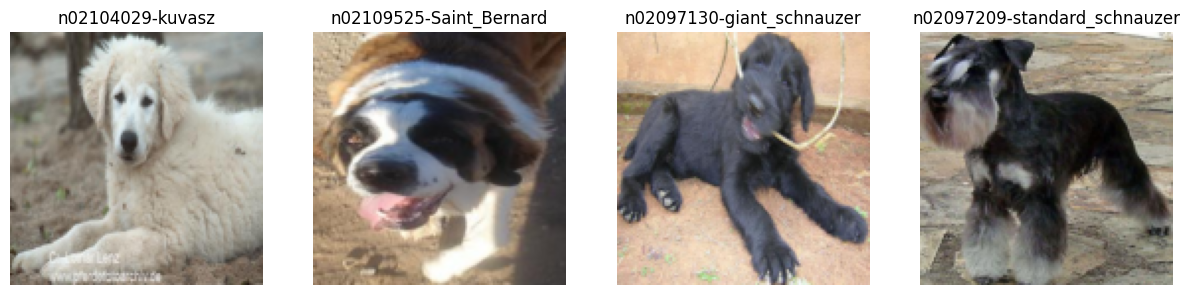

In [7]:
# A function to visualize a batch of images from the data loader
def visualize_batch(loader, label_dict, num_samples=4):
    # Get random samples from the data loader
    random.seed()
    indices = random.sample(range(len(loader.dataset)), num_samples)
    images, labels = zip(*[loader.dataset[i] for i in indices])
    
    # Plot the images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.permute(1, 2, 0)) 
        ax.set_title(label_dict[label])
        ax.axis('off')
    plt.show()

# Visualize the training set
visualize_batch(train_loader, label_dict)

A simple visualization function was defined to display a random sample of images from the dataset. This ensures the data is loaded correctly and the labels are assigned properly. Here we can see that the dataloaders are working as expected and the images are being transformed correctly with the bounding box cropping to focus on the dog in the image.

## Simple CNN

### **Q5: Define a simple CNN** ###

PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output.

Write the `CNN` class to define a Convolutional Neural Network (CNN) where:
- The first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5, a stride of 1, and padding of 2 pixels. The output of `conv1` is fed into a ReLU activation followed by a Max-pooling operator with a kernel size of 2.
- The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5, a stride of 1, and padding of 2 pixels. This should be followed by a ReLU activation and a max-pooling operator with a kernel size of 2.
- The last layer is a fully-connected layer (`fc1`), which will finally output the dog breed that needs to be predicted.

In this code you should define the `__init__` and `forward` member functions.

Lastly, print the number of parameters in the model (using `torchsummary.summary`)

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

**(10 marks)**

In [8]:
# A simple CNN model subclassing the nn.Module class
class CNN(nn.Module):
    # Initialization function definines the layers
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Activation function
        self.relu = nn.ReLU()
        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) 

        # Fully connected layer
        self.fc1 = nn.Linear(32, num_classes)

    # Forward function defines the forward pass
    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Second convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Global average pooling
        x = self.global_avg_pool(x) 
        # Flatten the tensor 
        x = x.view(x.size(0), -1) 
        # Fully connected layer
        x = self.fc1(x)  
        return x

# Initialize the CNN
simple_model = CNN()

# Move the model to the device
simple_model = simple_model.to(device)

# Set the model path
simple_model_path = './Model/Simple-CNN/simple-model.pth'

# Print the number of parameters in the model
summary(simple_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Linear-8                  [-1, 120]           3,960
Total params: 9,048
Trainable params: 9,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.75
Params size (MB): 0.03
Estimated Total Size (MB): 6.97
----------------------------------------------------------------


The simple CNN model class was defined following the layer architecture laid out in the question instructions. The model consists of two convolutional layers, each followed by a ReLU activation function and a max pooling layer.

The importance of the Global Average Pooling (GAP) layer was noted as initially this was left out and the model was heavily overfitting. The training set instantly reached 100% accuracy while the validation set was stuck at 10% accuracy. This was due to the model having too many parameters and not being able to generalize well. So introduction of the GAP layer was necessary to reduce the number of parameters before the fully connected layer, allowing the model to generalize better.

We only need one fully connected layer at the end to map the features to the number of classes. The model was then moved to the GPU device and the number of parameters was printed using torchsummary to verify the model architecture.

### **Q6: Train and evaluate the simple CNN** ###

1.   Write the code to train and evaluate the CNN specified in **Q5**. Use an Adam optimizer with the learning rate set to 0.001.
2.   Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs.
3.   Save the best performing model in the folder `./Model/Simple-CNN/model.pth`.
4.   Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

*ℹ️ NOTE: Apart from the accuracy, feel free to check out any other metrics that may be of relevance. Apart from the overall performance, consider also checking out the performance across classes.*

*ℹ️ NOTE: The model should take less than 1 hour to train.*

**(15 marks)**

In [9]:
def indv_epoch_train(model, train_loader, criterion, optimizer, device):
    # Set the model to training mode
    model.train()
    
    # Initialize the running loss and correct predictions
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate over the training data
    for images, labels in train_loader:
        # Move the images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        # Add the loss to the running loss
        running_loss += loss.item()
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update the total and correct predictions
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate the epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    # Calculate the accuracy
    train_accuracy = correct_train / total_train
    # Return the epoch loss and accuracy
    return epoch_loss, train_accuracy 

A modular appraoch to testing and evaluting was taken so that repetitive coding could be avoided and the usage would be easier.

The indv_epoch_train function is straight forward, it takes the model, train_loader, criterion, optimizer and device as input and returns the epoch loss and accuracy. So this would need to be iteratively called for each epoch in the training loop. 

In [10]:
def evaluate_model(model, val_loader, criterion, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and correct predictions
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Iterate over the validation data without gradient tracking
    with torch.no_grad():
        # Iterate over the validation data
        for images, labels in val_loader:
            # Move the images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Add the loss to the running loss
            running_val_loss += loss.item()
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Update the total and correct predictions
            correct_val += (predicted == labels).sum().item()
            # Update the total number of samples
            total_val += labels.size(0)
    # Calculate the validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    # Return the validation loss and accuracy
    return val_loss, val_accuracy

The evaluate_model function is similar to the indv_epoch_train function, but it will work on the validation set and won't update the model weights. It is used to evaluate the model on the validation set. This function will also be part of an iterative process to evaluate the model on the validation set after each epoch.

In [11]:
def metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs):
    # Create a figure and a set of subplots
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.grid(True)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs')
    plt.grid(True)
    plt.legend()

    plt.show()

The metric_plot function takes the training and validation accuracies and losses as input and plots them against the number of epochs. This is a simple but effective way to visualize the training and validation performance of the model. It helps identify model issues such as overfitting or underfitting, and can be used to tune hyperparameters accordingly. 

In [12]:
def save_model(model, model_path, val_acc, best_acc, epoch, optimizer=None, save_interval=10):
    # Determine if the model should be saved
    save_condition = (val_acc > best_acc) or (epoch % save_interval == 0)

    # Append 'best_' to the model path if the current validation accuracy is better than the previous best accuracy
    if val_acc > best_acc:
        model_pth = model_path.replace('.pth', '-best.pth')
    else:
        model_pth = model_path

    # Check the save condition
    if save_condition:
        # Save the model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_acc': val_acc,
            'best_acc': best_acc,
        }

        # Ensure the directory exists before saving
        os.makedirs(os.path.dirname(model_pth), exist_ok=True)
        
        # Save the model checkpoint
        torch.save(checkpoint, model_pth)
        # For best model we will have a different path than the recurrenct saving
        print(f"Model saved at {model_pth}")

        # Update the best accuracy if the current validation accuracy is better
        if val_acc > best_acc:
            best_acc = val_acc

    return best_acc

Another requirement was to save the best model trained. So the save_model function was created to save the model with the best validation accuracy. The function takes the model, model_path, val_acc, best_acc, epoch, optimizer, and save_interval as arguments. The function saves when the validation accuracy is better than the best accuracy or when the epoch is a multiple of the save_interval. The function also appends '-best' to the model path suffix if the current validation accuracy is better than the previous best accuracy. So two saved coppies of the model will be left after all the epoches, the most recently saved and the best saved. The function returns the best accuracy.

In [13]:
def train_eval(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    model_path,
    metric_plot_fn,
    indv_epoch_train_fn,
    evaluate_model_fn,
    save_model_fn,
    sheduler = None
):
   
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    best_accuracy = 0.0

    progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

    for epoch in progress_bar:
        # Training
        train_loss, train_accuracy = indv_epoch_train_fn(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation
        val_loss, val_accuracy = evaluate_model_fn(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if sheduler is not None:
            sheduler.step()

        # Save the best model
        best_accuracy = save_model_fn(model, model_path, val_accuracy, best_accuracy, epoch, optimizer)

        # Update the progress bar
        progress_bar.set_postfix_str(
            f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%"
        )

    # Plot metrics
    metric_plot_fn(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

    # Print highest validation accuracy
    print(f"Highest Validation Accuracy: {100 * best_accuracy:.2f}%")

    return

Using the modular functions defined above, we can now sum them in one train_eval function to train and evaluate the model. This function takes all the necessary parameters for the training and evaluation process and calls the functions in the correct order. We iterate over the number of epochs and save the best model based on the validation accuracy. We also plot the metrics and print the highest validation accuracy achieved.

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth
Model saved at ./Model/Simple-CNN/simple-model-best.pth


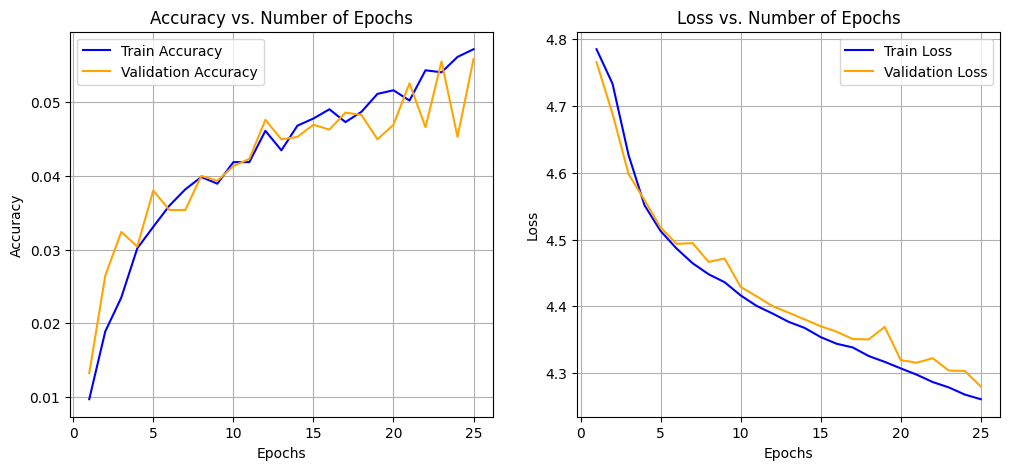

Highest Validation Accuracy: 5.59%


In [14]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)
# Define the number of epochs
num_epochs = 25

# Train and evaluate the model
train_eval(
    simple_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    simple_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model
)


We can now define the simple CNN models criterion of the loss function, optimizer with the required learning rate of 0.001. The train and evaluate function is called with the simple CNN model and with the progress bar displayed during training and the final plot, we are able to identitfy the characteristics of the model during training and evaluation process.

As mentioned previously an augmented transform was initially applied to the training set. This showed clear signs of overfitting in the metrics plot, as the training accuracy quickly saturated to 100% and the validation accuracy remained low. This is a clear sign of overfitting, where the model is memorizing the training data and not generalizing well to the validation data. 

So after using the simplified transformation we can see how both the training and validation accuracy and loss follow almost identical trends, which is a good sign of a well-trained model. With increasing epoches the training and validation accuracy increases and the loss decreases, having decreasing returns the higher the number of epoches. However, with 25 epoches a saturation point is not reached, so the model could be trained for more epoches to further improve the accuracy.

The best accuracy of the proposed network after 25 epochs is **5.59%**

The simple CNN model was designed as a baseline model to build off of its objective wasn't to achieve high accuracies from the get go. It served as a starting point to understand the data and the way it must be handeled to train a model effectively on it without overfitting or underfitting. Infact the accuracy of the model is very poor and will not be able to predict the breed of the dog in the image correctly. The model is very simple and shallow, lacking the capacity to learn the features of the images. The model needs to be more complex and deep to be able to learn the features of the images and predict the breed of the dog correctly. However, its purpose was to serve as a starting point to understand the data and the way it must be handeled to train a model effectively on it without overfitting or underfitting.

---------------------------------------

Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

Try it out using an image in your testing set.

In [15]:
def predict(model, model_path, img_path, label_dict):
    # Load the model and its checkpoints from the model path
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    # Set the model to evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),  
        transforms.Lambda(lambda img: img.convert('RGB')), 
        transforms.ToTensor(),
    ])
    # Get the tensor representation of the image    
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Perform the prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

    # Get the predicted breed
    predicted_breed = label_dict.get(predicted.item(), "Unknown Breed")
    # Get the confidence of the prediction
    confidence = confidence[predicted.item()].item()

    # Print the predicted breed and confidence
    print(f"Predicted Breed: {predicted_breed}")
    print(f"Confidence: {confidence:.2f}%")
    
    return 

The predict function is used to load the model and its checkpoints from the specified model path, set the model to evaluation mode, load and preprocess the image. The transformation applied to the image is the same as the one used during training, ensuring consistency that in turn helps the model to identify the features it was trained on. The image is then passed through the model to obtain the predicted label and the confidence of the prediction. Finally, the predicted breed and confidence are printed out. From this test we can verify the inspection made during training and validation. With confirmation of the model's ability to predict correctly.

In [16]:
# Get a random image path and remove it from the test set
pred_img, pred_breed = test_set.pop(random.randint(0, len(test_set) - 1))

simple_model_path = './Model/Simple-CNN/simple-model-best.pth'

# Print the image path
print(f"Image Path: {pred_img}")
# Print the actual breed of the dog
print(f"Actual Breed: {label_dict[pred_breed]}")

# Predict the breed
predict(simple_model, simple_model_path, pred_img, label_dict)

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099601-golden_retriever/n02099601_1768.jpg
Actual Breed: n02099601-golden_retriever
Predicted Breed: n02110806-basenji
Confidence: 3.26%


A random image path is selected from the test set and the model path is redefine to the best model path. We are not baising any model for the final test by using an image from the test set, since the prediction is done in evaluation mode. Furthermore, each model is predicted on the same image, that is popped from the test set to avoid any bias. The image path and the actual breed of the dog of the dog to be predicted are printed. The prediction function is called and the predicted breed and the confidence of the prediction are printed.

Clearly the model as assumed above failed to predict the image, as it missclasified the breed of the dog. With very low confidence index. The confidence index is an extra metric that gives us the Nueral Network's certianty in its prediction based off of the softmax function. The higher the confidence index the more certain the model is in its prediction, which likely means the model has alot of valid data to back up its prediction. The lower the confidence index the less certain the model is in its prediction, which likely means the model has less valid data to back up its prediction.

### **Q7: Improve the simple CNN's performance** ###

Provide an overview of the model's characteristics (e.g. hyperparameters) that can be modified to try and improve performance. Then, try to improve the performance, by varying some characteristics, and train *at least* 1 additional model.

Explain the reasoning behind the hyperparameters chosen for modification, and the reasoning behind the values that are set (e.g. if you reduce the learning rate, explain why you have done this).

Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs. Show the results of any other metrics that are deemed relevant.

ℹ️ *NOTE: While it is not strictly necessary to improve performance (although desirable), it is important to discuss any increase or decrease in performance, across all evaluation metrics considered (i.e. discuss why did performance increase/decrease?)*

ℹ️ *NOTE: Do NOT change the number of epochs. Similar to the model in Q6, the models should take less than 1 hour each to train.**

**(10 marks)**

In [17]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, init=32, dropout=0.5): 
        super(ImprovedCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=init, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=init, out_channels=init*2, kernel_size=5, stride=1, padding=2)
        # Added third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=init*2, out_channels=init*4, kernel_size=5, stride=1, padding=2)

        # Batch Normalization layers for each convolutional layer
        self.bn1 = nn.BatchNorm2d(init)
        self.bn2 = nn.BatchNorm2d(init*2)
        self.bn3 = nn.BatchNorm2d(init*4)

        # Activation function
        self.relu = nn.ReLU()

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(init * 4, 64)  # Bottleneck to 64
        self.fc2 = nn.Linear(64, num_classes)  # Final layer matching num_classes

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output to spatial dimension of 1
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)  # Bottleneck layer
        x = self.relu(x)  # Apply activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Final layer with class scores
        return x

# Initialize the Improved CNN
improved_model = ImprovedCNN(num_classes)

# Move the model to the device
improved_model = improved_model.to(device)

# Set the model path
improved_model_path = './Model/Improved-CNN/improved-model.pth'

# Print the model summary 
summary(improved_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          51,264
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         204,928
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-13            [-1, 128, 1, 1]               0
           Linear-14                   

The simple CNN model was defined with two very basic convolutional layers and a fully connected layer. Apart from these layers, no other layers were used. This restricted use of layers and parameters may limit the model's ability to learn the dataset effectively, leading to low accuracy.

Some parameters that can be tuned to improve the model are:

- Number of convolutional layers
- Normalization in each convolutional layer
- Dropout layer to prevent overfitting
- Freezing the weights of the convolutional layers
- Lowering the learning rate
- Using a different optimizer that may be more suitable for the model
- Using a different loss function that may be more suitable for the model
- Weight decay to prevent overfitting
- Scheduling the learning rate

To address these issues, the ImprovedCNN model was defined with:
- three convolutional layers
- batch normalization layers
- bottleneck layer 
- dropout layer

Using three convolutional layers is still considered a shallow network but it is deeper than the simple CNN model. Which will allow the model to learn more features as the parameters increase.

The batch normalization layers help in normalizing the input to the next layer, so there is a more seamless and faster learning process. 

The bottleneck layer, although it may seem inefficient, reduces the number of parameters below the trageted number of classes before increasing them again to match it. This is actually an effective way to reduce the model's complexity and prevent overfitting. Since the fully connected layer will have fewer parameters to learn, the model will be less likely to overfit the training data. However, if too much information is lost in the bottleneck layer, the model may not be able to learn the necessary features to make accurate predictions. So a balance must be struck between reducing the number of parameters and maintaining the necessary information.

The bottleneck layer is also followed by a dropout layer. The dropout layer helps in preventing overfitting by randomly setting a fraction of the input units to zero at each update during training. This means that the model will not rely on a single feature to make predictions.

Then the final layer is the fully connected layer with the number of classes as the output. The model is once again trained with all the classes and moved to the device.

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth
Model saved at ./Model/Improved-CNN/improved-model-best.pth


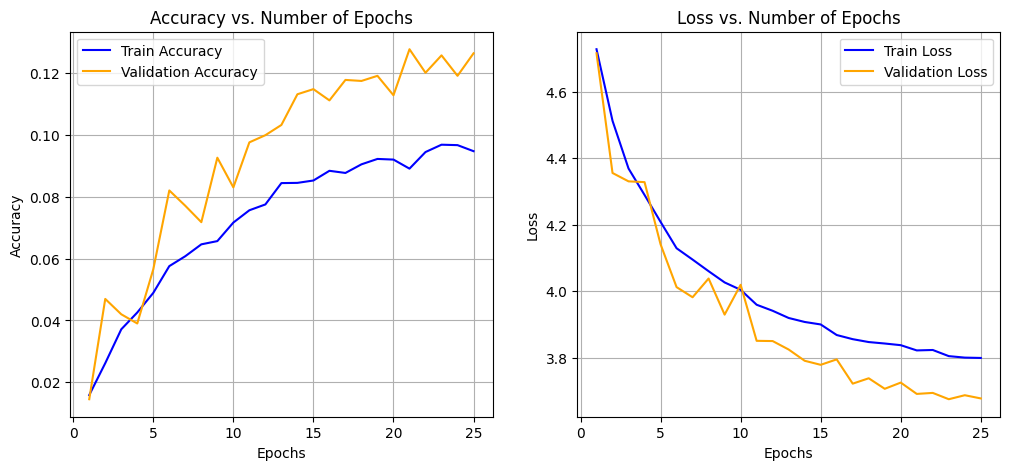

Highest Validation Accuracy: 12.76%


In [18]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer with a lower learning rate
optimizer = optim.Adam(improved_model.parameters(), lr=0.0005) 
# Define the scheduler to reduce the learning rate every 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.5) 

# Define the number of epochs
num_epochs = 25

# Train and evaluate the improved model
train_eval(
    improved_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    improved_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model,
    scheduler
)

Further-more, appart from the new improved model definition, we also make use of a lower learning rate (0.0005) which essentailly give the model more time to learn the features of the dataset and will help it converge to a better solution. As well as a learning rate scheduler which will reduce the learning rate by half every 5 epochs. This continously reduces the learning rate as the model trains, allowing it to converge to a better solution.

The improved model did indeed have a higher accuracy than the simple model with **12.76%**. However, this accuracy result is still super low and indicates the model is still not learning the features of the images well. Although we increases the depth of the model by 1 layer and added batch normalization and dropout. It seems clear that the dataset requires a deep neural network to learn the features of the images.

The metrics plot shows that the model is well fitted, acutally having the validation set perform better than the training set in accuracy and loss metrics. This tells us that the model is not overfitting the training data and is generalizing well to the validation set. Good signs that our preventitive measures are working to prevent overfitting and actually improve the generalization of the model.

The main increase in accuracy however, likely comes from the decrease in learning rate and the learning rate scheduler. This is a simple metric that usually improves the performance of the model by allowing it to learn the features of the dataset better and converge to a better solution. The learning rate scheduler is a simple yet effective technique to improve the performance of the model whilst training and is a good practice to implement in most models to have a saturated learning rate that allows the model to converge to a better solution.

In [19]:
# Redefine the model path to get the best model
improved_model_path = './Model/Improved-CNN/improved-model-best.pth'

# Print the image path
print(f"Image Path: {pred_img}")
# Print the actual breed of the dog
print(f"Actual Breed: {label_dict[pred_breed]} \n")

# Predict the breed
predict(improved_model, improved_model_path, pred_img, label_dict)

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099601-golden_retriever/n02099601_1768.jpg
Actual Breed: n02099601-golden_retriever 

Predicted Breed: n02107312-miniature_pinscher
Confidence: 3.75%



Once again the model is not able to predict the breed of the dog correctly, still with very low confidence. The fact that the confidence correlates closely with the inaccuracy of the model is a good indicator that there isn't any overfitting or confusion between classes. The model is simply not able to learn the features of the images well enough to make accurate predictions. This is why a deeper and more complex model is needed to learn the features of the images better.

## Deep CNNs

### **Q8: Understanding deep CNN architectures proposed in literature** ###

There are several deep CNN methods that achieve very high classification rates. The following is a list of papers that you should check out:

1. Alexnet  [[1]](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
2. VGG model [[2]](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/simonyan15.pdf)
3. ResNet [[3]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

Discuss what innovations each network introduced, and what contributed to increased performance.

**(10 marks)**

**A8**: 

Deep neural networks are characterized by the number of layers they contain. The more layers a network has, the more complex features it can learn. However, as the number of layers increases, training the network becomes more challenging due to problems such as the vanishing gradient problem, where gradients become very small, making it difficult to update the weights effectively. The porblem of time complexity also arises as the number of layers increases. So innovative solutions are required to overcome these challenges and train deep networks effectively. 

**AlexNet (2012)** was the first deep convolutional neural network to achieve high accuracy on the ImageNet dataset. It introduced several key innovations that paved the way for future advancements in deep learning. Some of the key innovations of AlexNet include:

- ReLU Activation Function: AlexNet popularized the use of the Rectified Linear Unit (ReLU) activation function, which replaced the sigmoid and tanh functions since it enabled training due to its handeling of the vanishing gradient problem.

- Dropout Layer: To prevent overfitting, AlexNet employed a dropout layer that effectively reduced the risk of overfitting by randomly setting a fraction of the input units to zero during training. This works fine as long as the randomness is kept or else the model will be more baised then before.

- Data Augmentation: The model used data augmentation techniques such as random cropping, flipping, and color jittering to artificially essentially increasing the size of the training set by replicating the images with slight modifications. This helped the model generalize better and reduce overfitting. It also helped in making the model more robust to variations in the input data.

- Max Pooling Overlapping: AlexNet used max pooling with overlapping regions to reduce the spatial dimensions of the feature maps while preserving the most important features. So in short by applying max pooling over two overlapping regions, the model can learn more complex features. Since the overlapping regions are used, the model can learn more complex features.

- GPU Acceleration: Through the use of GPU's and their ability to perform parallel computations, AlexNet was able to significantly speed up the training process, making it possible to train deeper networks on large datasets. This was a significant breakthrough as it allowed researchers to train deep networks more efficiently and effectively.


**The VGG (2014)** model built upon the success of AlexNet by introducing a deeper network architecture with the main focus on having a smaller filter size. The key innovations of VGG include:

- Small 3x3 Filters: VGG used small 3x3 convolutional filters throughout the network, which allowed it to increase the depth of the network while maintaining manageable computational complexity. The small filter is essentailly the GPU kernel size which is used to convolve over the image. It basically allowed for the same complexity of higher filter size but with less computational cost since less number of parameters are required.

- Deep Architecture: VGG enforced the idea that increasing the depth of the network could lead to better performance. This was mostly possible due to the gain of using small 3x3 filters. The VGG-16 and VGG-19 models, with 16 and 19 weight layers respectively, achieved higher accuracy on the ImageNet dataset compared to AlexNet. The deeper architecture allowed the model to learn more complex features and patterns in the data.

- Consistent Architecture: VGG maintained a consistent architecture throughout the network, with multiple convolutional layers followed by max pooling layers. This regular pattern made it easier to design and train the network, as well as to replicate the architecture for different tasks. This also made the model easy to understand and implement. It's fully connected layers was also consistently simplified having 3 layers targeting the output classes by making high level decisions.


**ResNet (2015)** addressed the limitations of previous architectures to train very deep neural networks by introducing the concept of residual connections. The key innovations of ResNet included:

- Residual Connections: Introducing the concept of skip connections, which is essentially a way to bypass one or more layers if the model finds it necessary. This innovation helped mitigate the vanishing gradient problem and enabled the training of very deep networks. The skip connections allowed gradients to flow more easily through the network, making it possible to train networks with over 100 layers.

- Deeper Networks: As a result of the residual connections, ResNet was able to train very deep networks with over 100 layers, achieving higher accuracy on the ImageNet dataset. The ability to train deeper networks allowed the model to learn more complex features and patterns in the data, leading to improved performance.

**Conclusion**


In summary, each of these networks introduced key innovations that resulted in continuous improvements in the field of deep learning and the resultant accuracy of image classification models. The main focal innovations can be summarized as follows:

**AlexNet**
Introduced ReLU activation, dropout, data augmentation, and GPU acceleration.
- Accuracy: 84.7%
- Error rate: 15.3%
- Number of layers: 8
- Number of parameters: 60 million

**VGG**
Used small 3x3 filters and a deeper architecture.
- Accuracy: 92.7%
- Error rate: 7.3%
- Number of layers: 16 or 19
- Number of parameters: 138 million

**ResNet**
Introduced residual connections to train very deep networks.
- Accuracy: 96.5%
- Error rate: 3.5%
- Number of layers: Over 100
- Number of parameters: 152 million

### **Q9: Define, train, and evaluate a deep CNN** ###

Based on your observations in **Q8**, write the class for a deep CNN model that aims to achieve a better performance than the simple CNN model above, explaining the reasoning behind the design of your model. The number of model parameters should be less than 75M.

Train the model, and plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Show the results of any other metrics that are deemed relevant, and discuss your observations.

*ℹ️ NOTE: The model should take less than 3 hours to train.*

**(10 marks)**

In [20]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes, init_channels=32, depth=5):
        super(DeepCNN, self).__init__()

        # Cap initial channels for regularization
        init_channels = min(init_channels, 64)  

        # Initialize the features block
        self.features = self.build_features(init_channels, depth)

        # Limit the final number of channels to 2048 so we wont exceed 75M parameters
        final_channels = min(init_channels * (2 ** (depth - 1)), 2048)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # Classification layer
        self.classifier = nn.Linear(final_channels, num_classes)


    # Function to build the convolutional and pooling layers
    def build_features(self, init_channels, depth):
        # Builds the convolutional and pooling layers dynamically.
        layers = nn.Sequential()
        in_channels = 3  # Input is RGB images
        
        # Iterate over the depth of the model
        for i in range(depth):
            # Set the number of output channels for this layer
            out_channels = min(init_channels * (2 ** i), 2048)

            # Add the convolutional block
            layers.add_module(f'conv{i+1}', self.conv_block(in_channels, out_channels))
            
            # Add pooling after every two convolutional layers except the last
            if (i % 2 == 1) and (i != depth - 1):
                layers.add_module(f'pool{i+1}', nn.MaxPool2d(2, 2))

            # Update input channels for the next layer
            in_channels = out_channels
        
        # Return the layers
        return layers

    # Function to create a convolutional block
    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        # Convolutional block: Conv2d, BatchNorm2d, ReLU
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        
        # Global average pooling
        x = self.global_pool(x)
        # Flatten the tensor
        x = x.view(x.size(0), -1)
    
        # Classification
        x = self.classifier(x)
        return x

# Initialize the Deep CNN
deep_model = DeepCNN(num_classes)

# Move the model to the device
deep_model = deep_model.to(device)

# Set the model path
deep_model_path = './Model/Deep-CNN/deep-model.pth'

# Print the model summary to check parameters
summary(deep_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,432
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,728
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         294,912
      BatchNorm2d-12          [-1, 256, 64, 64]             512
             ReLU-13          [-1, 256, 64, 64]               0
        MaxPool2d-14          [-1, 256,


Following the analysis of the history of deep models such as AlexNet, VGG, and ResNet, we can see that these models have a common feature which is increasing the depth of the model. This is achieved by stacking multiple convolutional layers followed by pooling layers. So we will try to implement a deep model that follows this pattern.

Our deep model is defined in a highly parameterized manner, where we can adjust the depth, initial channels, and final channels of the model. This enables us to experiment with different depths and initial channels to find the optimal configuration for our deep model, whilst still keeping to the restriction of 75M parameters. The model defines to additional functions, build_features and conv_block, to dynamically construct the convolutional and pooling layers based on the provided depth and initial channels. A collection of the stacked convolutional and pooling layers is defined as a single layer type called features. The forward function passes the input through the feature extraction layers, global average pooling, and classification layers.

The features block is constructed by iterating over the depth of the model in the build_features function. For each iteration, the number of output channels is set based on the initial channels and the current depth. The conv_block function is used to create a convolutional block consisting of a convolutional layer, batch normalization, and a ReLU activation function. The conv_block is added to the features block, and a pooling layer is added after every two convolutional layers except the last. The final number of channels is limited to 2048 to ensure that the model does not exceed 75M parameters.

This method of dynamic depth was inspired by the VGG model, since it has consistent architecture with varying depth. It was tought that a similar approach could be used to create a deep model with varying depth. The model is then moved to the device and the model path is set to save the model checkpoints. The model summary is printed to check the number of parameters and layers in the model.

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved at ./Model/Deep-CNN/deep-model-best.pth
Model saved 

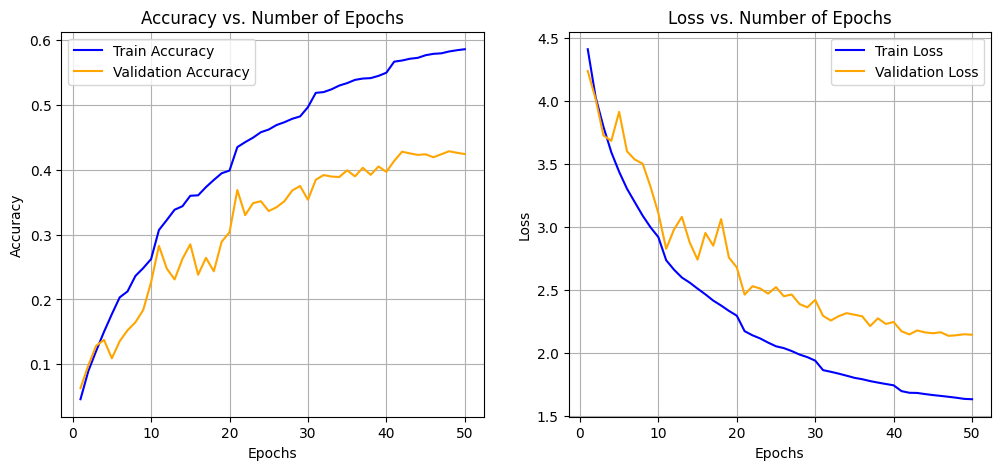

Highest Validation Accuracy: 42.84%


In [21]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer kepping the lower learning rate
optimizer = optim.Adam(deep_model.parameters(), lr=0.0005)  
# Define the scheduler as before
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Define the number of epochs
num_epochs = 50

# Train and evaluate the deep model
train_eval(
    deep_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    deep_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model,
    scheduler
)

We use the same criteration, optimizer and scheduler as the previous model. But with the increased epochs size defiend in the question.

The Deep CNN model showed a great jump in accuracy compared to the previous models. It confirms our hypothesis that a deeper model was required. Yet the model is still on the lower end of the accuracy spectrum, the improvements shown due to depth are promising. So further exploiting the depth of the model and tuning the hyperparameters can lead to better results.

The metric plot shows that the model is now begining to saturate using the 50 epochs. Which is a good sign that we are allowing the model to learn to its best potential. The validation metrics fall a bit behind the training metrics but do not show any signs of overfitting. The model is a clear improvement over the previous models and indicator that deeper models are required for this task.

In [22]:
# Redefine the model path to get the best model
deep_model_path = './Model/Deep-CNN/deep-model-best.pth'

# Print the image path
print(f"Image Path: {pred_img}")
# Print the actual breed of the dog
print(f"Actual Breed: {label_dict[pred_breed]} \n")

# Predict the breed
predict(deep_model, deep_model_path, pred_img, label_dict)

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099601-golden_retriever/n02099601_1768.jpg
Actual Breed: n02099601-golden_retriever 

Predicted Breed: n02088094-Afghan_hound
Confidence: 27.93%



The predictions have now come to almost a 50/50 chance of being correct. This is still far off from the accuracy we would like to achieve. But we have made significant progress in improving the model architecture and training process. 

### **Q10: Perform Transfer Learning** ###

Use the [`vgg16_bn` *pre-trained* model](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html#torchvision.models.vgg16_bn), using `weights='IMAGENET1K_V1'`, to perform transfer learning using the Stanford Dogs dataset.

Explain the modifications and implementations done to perform transfer learning, in the Markdown text cell below.

Based on your observations of the trained model's performance, try to improve the performance by training additional models (see the cell below for more details).

For each case:

* Plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Similar to previous questions, show the results of any other metrics that are deemed relevant.

* Discuss how you are performing the fine-tuning

* Discuss observations from model training and evaluation

*ℹ️ *NOTE: Feel free to use the function you created in Q6 to input an image and a model and output the breed of the dog depicted in the image as determined by the model.*

*ℹ️ NOTE: The model should take less than 2.5 hours to train.*

**(15 marks)**

In [23]:
# Set the base model to be downloaded 
vgg16_base = torchmodels.vgg16_bn(weights='IMAGENET1K_V1')
# Check if path exists'
if not os.path.exists('./Model/VGG16'):
    os.makedirs('./Model/VGG16')
    
# Define the base model path
vgg16_base_path = './Model/VGG16/vgg16-base.pth'
# Save the base model locally for multiple uses
torch.save(vgg16_base.state_dict(), vgg16_base_path)

To eliminate the need to download the model every time, we can save the model with the specified weights locally and load it from the local path. So we save a base model of the vgg16_bn with the ImageNet weights to the a local path and then it can be loaded, effectively saving time and bandwidth.

In [24]:
# Initialize the VGG16_bn model
vgg16_bn_model = torchmodels.vgg16_bn(weights=None)
# Load the base model weights
vgg16_bn_model.load_state_dict(torch.load(vgg16_base_path))

# Change the last layer output to match the number of classes
vgg16_bn_model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the device
vgg16_bn_model = vgg16_bn_model.to(device)

# Set the model path
vgg16_bn_model_path = './Model/VGG16/vgg16-bn-model.pth'

# Print the model summary to check parameters
summary(vgg16_bn_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,


To test the base model and identify any areas of imporvement related to our specfic dataset, we can train the base model and compare the results with the improved models. We laod the locally saved base model and define a new model with the last layer changed to match the number of classes. We then define the model path and print the model summary to check the parameters.

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth
Model saved at ./Model/VGG16/vgg16-bn-model.pth
Model saved at ./Model/VGG16/vgg16-bn-model.pth
Model saved at ./Model/VGG16/vgg16-bn-model-best.pth


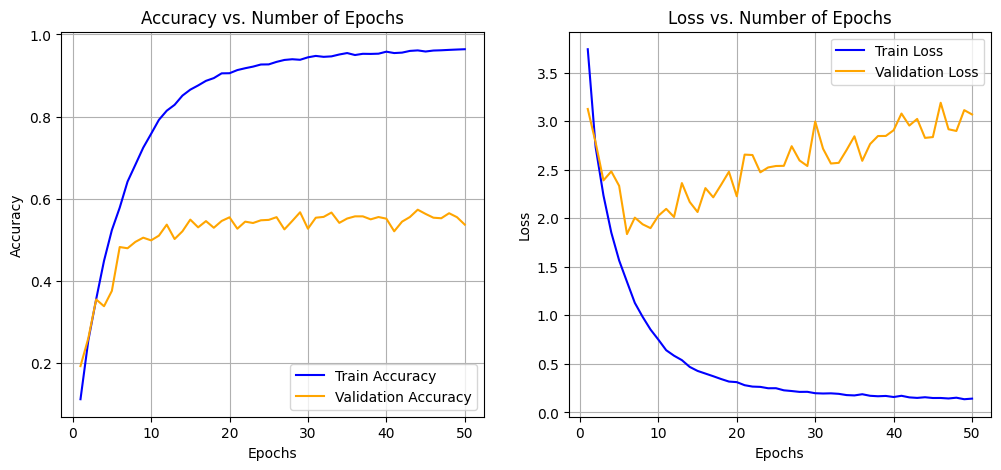

Highest Validation Accuracy: 57.32%


In [25]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(vgg16_bn_model.parameters(), lr=0.001) 
# Define the number of epochs
num_epochs = 50

# Train and evaluate the VGG16_bn model
train_eval(
    vgg16_bn_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    vgg16_bn_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model
)

Using default parameters for the loss function, optimizer and number of epochs, we trained and evaluated the base VGG16_bn model on the dataset. The model was able to achieve a best validation accuracy of **57.32%** after 50 epochs. The model was saved at the path './Model/VGG16/vgg16-bn-model-best.pth'.

The metrics give alot of insight on the models performance. The training set follows very steady curves and reaches super high accuracy and low loss. The validation set is a bit more volatile. For accuracy, it seems to saturate very quickly with the training set, but then osscilates arounds the 50% mark. The loss initially decreases, but then starts to increase again. This is a sign of overfitting. This could be due to the large number of parameters in the model, which could be causing the model to memorize the training data rather than generalize well to unseen data. This is a common issue with deep models, especially when the dataset is not large enough to support the number of parameters in the model.

In [26]:
# Redefine the model path to get the best model
vgg16_bn_model_path = './Model/VGG16/vgg16-bn-model-best.pth'

# Print the image path
print(f"Image Path: {pred_img}")
# Print the actual breed of the dog
print(f"Actual Breed: {label_dict[pred_breed]} \n")

# Predict the breed
predict(vgg16_bn_model, vgg16_bn_model_path, pred_img, label_dict)

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099601-golden_retriever/n02099601_1768.jpg
Actual Breed: n02099601-golden_retriever 

Predicted Breed: n02099601-golden_retriever
Confidence: 99.93%



**A10**: 

It was observed that the VGG16_bn base model performed better than the other custom-defined models we tried optimizing earlier. This is due to the fact that VGG16_bn is an established model that has been rigorously tested on the ImageNet dataset. Additionally, the model is deeper than any previous model we tried, which allows it to learn more complex features. The batch normalization layers also help in stabilizing the training process and reducing overfitting. The model was able to achieve a validation accuracy of **57.32%**, which is a significant improvement over the previous models. However, it is still far from an accurate model. The main flaw observed in this model's training is overfitting. The model is overfitting the training data and not generalizing well to the validation data. This can be seen from the training accuracy being much higher than the validation accuracy.

The model structure is already defined with depth, regularization techniques, and dropout layers. So if possible we dont want to redefine the model structure. We can try to improve the model by tuning the hyperparameters. Some of the hyperparameters that can be tuned are:

- Learning Rate - is one of the first hyperparamters we think of tuning and lowering to try help convergence. The learning rate can be lowered directly in the optimizer or gradually reduced using a scheduler. Usually a learning rate of 1e-3 is sufficient for most models, but we can try further lowering it to lets say 5e-4 or 1e-4. We do not always go straight to the lowest learning rate as it can slow down the training process and can actually have worse performance by getting stuck in local minima.

- Freezing Convolution Layers - can be used to prevent specific or all convolution layers from updating their weights during training. This might want to be done to draw focus to the fully connected layers or to prevent overfitting. So if a model is overfitting, we can try freezing the convolutional layers and only updating the fully connected layers.

- Pruning - is a technique used to remove unimportant weights from the model usually done in between epochs. This can help reduce the model size and improve performance. Pruning modules in pytorch can be used to remove weights below a certain threshold.

- Optimizers - can yeild different results on the same defined model. This is due to the fact that they work with different algorithmns made to serve different purposes. So varying and testing between optimizers can help improve the model. Some optimizers to try are Adam, SGD, RMSprop, Adagrad, etc.

- Number of Epoches - can be increased or decreased to see if the model converges better. Some models might need more time to learn the features and patterns in the data, as their accuries can be seen to still be increasing after 50 epochs. However, some models might converge very quickly and not need as many epochs, causing wasted time and resources.

Try to improve the performance, by varying characteristics such as the model hyperparameters, and train *at least* 2 additional models.

For each model, explain the reasoning behind (1) the *characteristics* chosen for modification, and (2) the *values* that are set (e.g. if you reduce the learning rate, explain why you have done this).

*ℹ️ NOTE: As before, the models should take less than 2.5 hours each to train.*

In [27]:
# Model 1: Frozen Convolutional Layers and Sheduler

# Intialize the vgg16 model
vgg16_1_model = torchmodels.vgg16_bn(weights=None)
# Load the base model weights
vgg16_1_model.load_state_dict(torch.load(vgg16_base_path))

# Freeze the convolutional layers
for param in vgg16_1_model.features.parameters():
    param.requires_grad = False
    
# Set the model to the device
vgg16_1_model = vgg16_1_model.to(device)

# Set the model path
vgg16_1_model_path = './Model/VGG16/vgg16-1-model.pth'

# Get the model summary
summary(vgg16_1_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,


When implementing pre-trained models such as the VGG16 we are using. Their cause to overfit comes from the inability to adapt to the specific dataset. The model is trained on a large dataset such as ImageNet, which contains a wide variety of images, not just dogs. So one way to fix this overfitting is to freeze the convolutional layers of the model. This will prevent the weights of the convolutional layers from being updated during training, allowing the model to focus on learning the classification task using the pre-trained features. This is done by identifying the convolutional layers and setting the requires_grad attribute to False. This way, the model will only update the weights of the fully connected layers, which are responsible for the classification task. 

With these changes, we expect the mitigate the overfitting and actually improve the model's performance on the dog dataset. We expect the validation metrics now to follow the trainings more closely and ultimately lead to accurate predictions on the test set.

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth


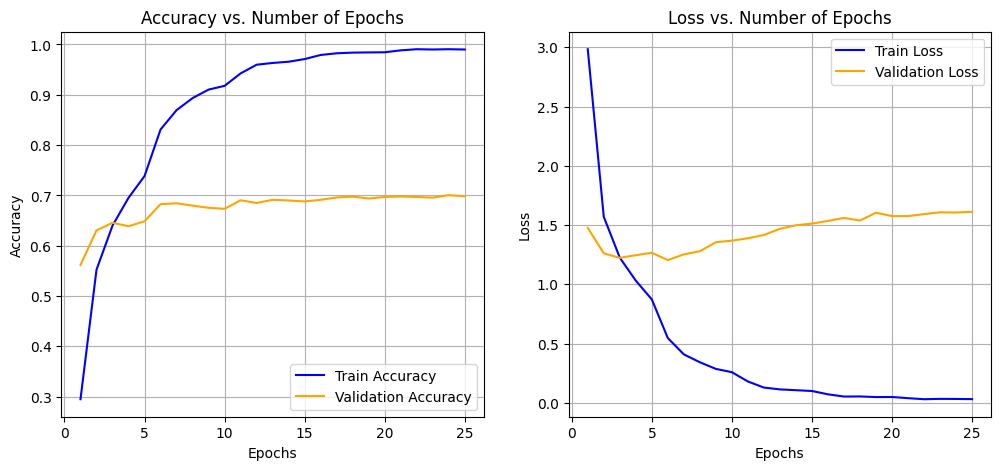

Highest Validation Accuracy: 70.05%


In [28]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(vgg16_1_model.parameters(), lr=0.0005)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
# Define the number of epochs
num_epochs = 25

# Train and evaluate the VGG16_bn model
train_eval(
    vgg16_1_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    vgg16_1_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model,
    sheduler=scheduler
)


In this implementation we keep the same criteria as the previous model, and use the same optimizer as we have only had increasing accuracies with it so far. But we lower the learning rate to 5e-4 and add a scheduler to reduce the learning rate by half every 5 epochs. This is done to try help the model converge better on top of the frozen convolutional layers that should help prevent overfitting. The epochs are also reduced to 25 since from previous base modle we note that there is no significant improvement after 25 epochs. 

The model is trained and evaluated with the metrics plotted and the best model saved. We have achieved one of two goals in this model, having an increase in the highest accuraacy achieved of **70.05%**. This is still a good an valid improvement from the previous model. However, freezing the convolution layers did not mitigate the overfitting problem as excpeted. Since we still have the training accuracy reaching a much higher value than the validation accurac and the validation loss actually increaing with epoches. The freezing of the convolution layers might have been too harsh as we froze all the layers and freezing only the first 15 migh have possibly been a better choice. In this case the frozen layers did not have a significant impact on the model's performance.

In [29]:
# Redefine the model path to get the best model
vgg16_1_model_path = './Model/VGG16/vgg16-1-model-best.pth'

# Print the image path
print(f"Image Path: {pred_img}")
# Print the actual breed of the dog
print(f"Actual Breed: {label_dict[pred_breed]} \n")

# Predict the breed
predict(vgg16_1_model, vgg16_1_model_path, pred_img, label_dict)

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099601-golden_retriever/n02099601_1768.jpg
Actual Breed: n02099601-golden_retriever 

Predicted Breed: n02099601-golden_retriever
Confidence: 100.00%



The new imporved model has managed to correctly predict the breed of the dog with full confidence level of **100%**. Showing that we are getting closer to a more robust accurate model and one that could potentially be used in a real-world scenario.

In [30]:
# Model 2: Parametized SGD Optimizer

# Initialize the VGG16_1 model
vgg16_2_model = torchmodels.vgg16_bn(weights=None)
# Load the base model weights
vgg16_2_model.load_state_dict(torch.load(vgg16_base_path))

# Change the last layer output to match the number of classes
vgg16_2_model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the device
vgg16_2_model = vgg16_2_model.to(device)

# Set the model path
vgg16_2_model_path = './Model/VGG16/vgg16-2-model.pth'

# Print the model summary to check parameters
summary(vgg16_2_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In this second implementation, we will use the default base model and its normal weight handling. The main focus and discovery will be on the optimizer. From the previous implementation, we noted that freezing the convolutional layers did not have any impact, so any model structure tweaking was avoided. It is believed that the optimizer could be the potential turning point.

Furthermore, as mentioned in the potential improvements section, the base model has been established. The task here is not to rebuild the structure but simply to tweak the parameters and tools to try to improve the training process specific to our dataset.

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model-best.pth
Model saved at ./Model/VGG16/vgg16-2-model.pth


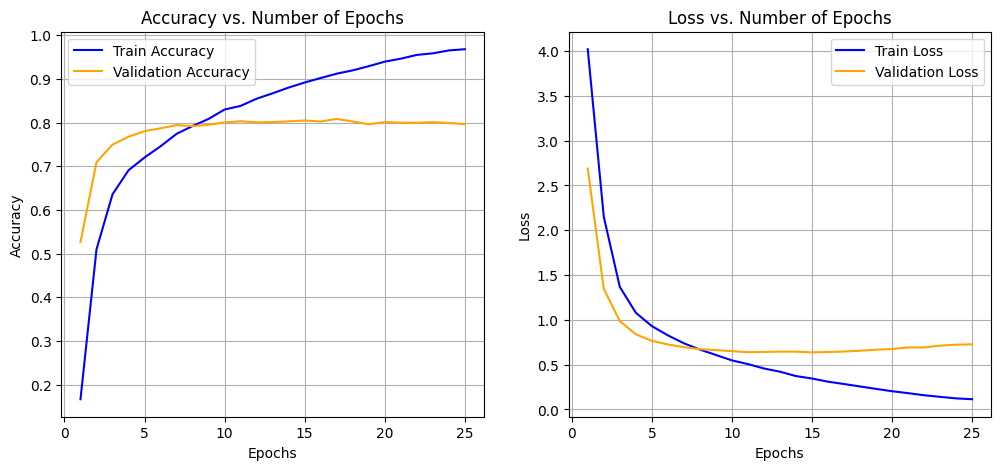

Highest Validation Accuracy: 80.83%


In [31]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Redefining a new optimizer using a different algorithm (SGD)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, vgg16_2_model.parameters()), lr=0.001, momentum=0.9)

# Define the number of epochs
num_epochs = 25

# Train and evaluate the VGG16_bn model
train_eval(
    vgg16_2_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    vgg16_2_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model
)


Analyzing our criterion and optimizer, we can keep the cirterion constant since this is just the method we determine the loss. However, we note that the optimizer is a key factor in the training process. The optimizer is responsible for updating the weights of the model. Previously, we have been using the Adam optimizer which is known to be adaptive and has a high learning rate. This optimizer proved good as it was able to adapt to the learning rate and converge faster. However, now that we have run into a problem of high varience and overfitting. Using a different type of optimizer like stochastic gradient descent (SGD) might be a better option, eliminating the adaptive learning rate and using a constant learning rate. The SGD optimizer is known to be more stable but less adaptive. This is due to the increased parameters the optimizer needs to perform well.

We are not increasing the learning rate from 0.001 as it is already a low enough value and increasing it further might cause oscillations in accuracy and divergence in the loss. We set a momentum of 0.9, which is a high value to ensure the model converges faster. The filtering of the parameters ensures that only those parameters that require gradients are updated. This method is also called selective training, when only a subset of weights are updated during training.

The model is then trained for 25 epochs only, since the base model of 50 did not have a significant improvement in past the 25th epoch. Our assumptions are easily proven by the trianing and evalutation process. The metrics plotted clearly show how the problems of overfitting and high variance have been mitigated. The validation accuracy and loss follows the respective training metric closely but we still have the validation loss increasing after the lowest point is reached. This is normal but if minimized can yield better results. The accuracy is also better than the previous models with a higher accuracy of **80.83%**.

In [32]:
# Redefine the model path to get the best model
vgg16_2_model_path = './Model/VGG16/vgg16-2-model-best.pth'

# Print the image path
print(f"Image Path: {pred_img}")
# Print the actual breed of the dog
print(f"Actual Breed: {label_dict[pred_breed]} \n")

# Predict the breed
predict(vgg16_2_model, vgg16_2_model_path, pred_img, label_dict)

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02099601-golden_retriever/n02099601_1768.jpg
Actual Breed: n02099601-golden_retriever 

Predicted Breed: n02099601-golden_retriever
Confidence: 99.13%


## Conclusions & Future Work

### **Q11: Model Deployment** ###

Let's say that you are asked to deploy one of your models in practice. Which of the models that you have trained would you select, and why?

ℹ️ *NOTE: Compare your models, and discuss any advantages, limitations, and any future work that could be performed to make the chosen model more suitable for real-world deployment.*

**(10 marks)**

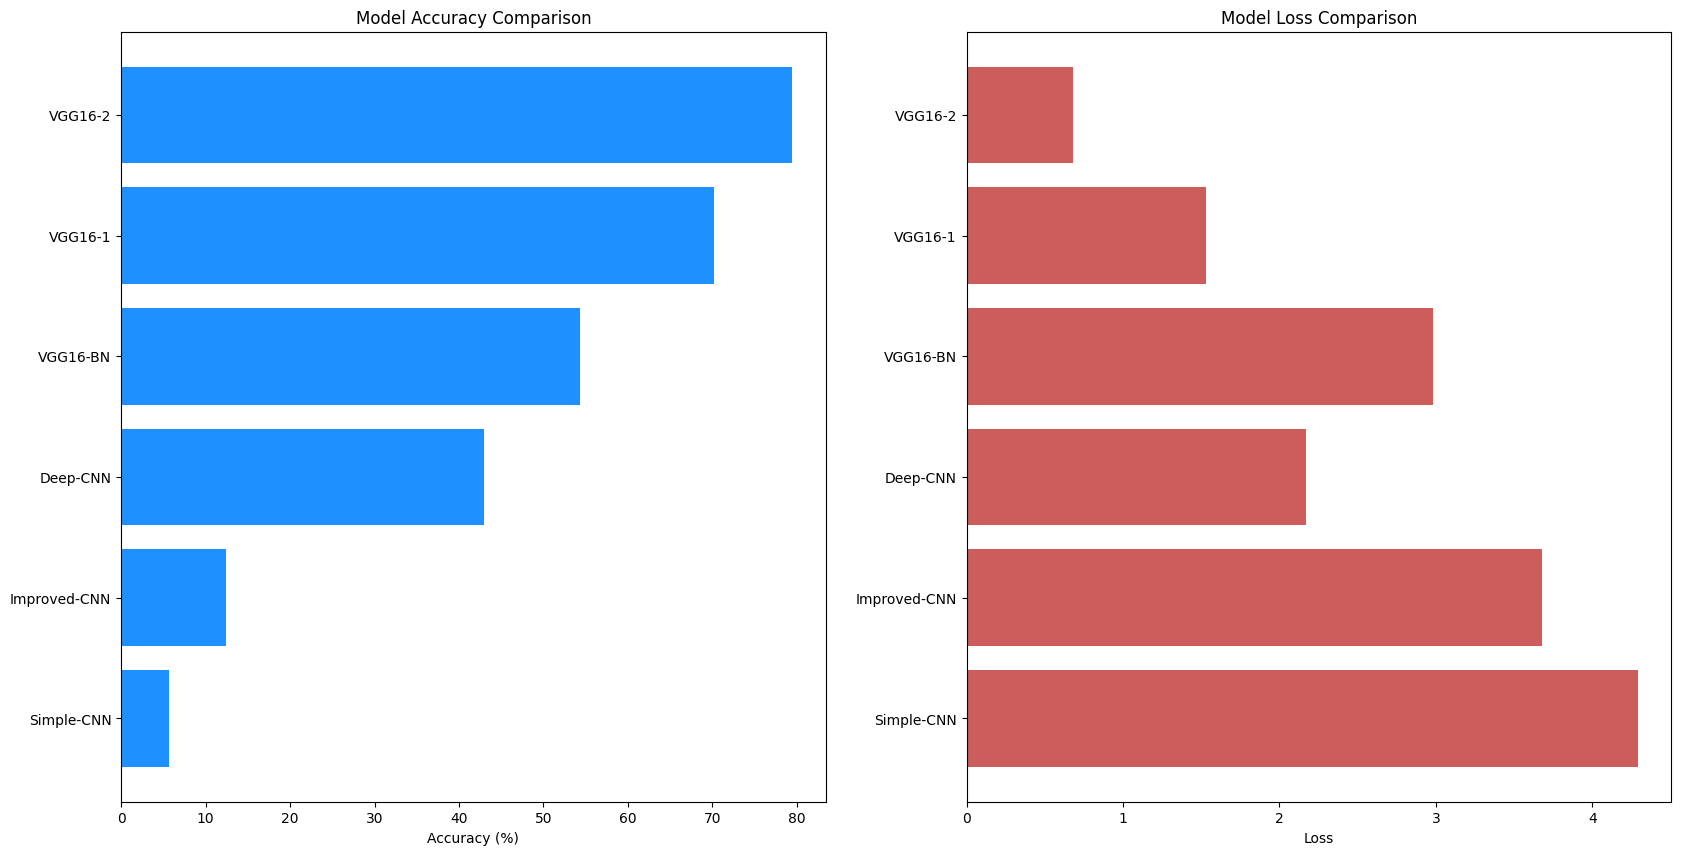

Simple-CNN Accuracy: 5.63%, Loss: 4.2888
Improved-CNN Accuracy: 12.41%, Loss: 3.6767
Deep-CNN Accuracy: 42.98%, Loss: 2.1708
VGG16-BN Accuracy: 54.27%, Loss: 2.9806
VGG16-1 Accuracy: 70.18%, Loss: 1.5302
VGG16-2 Accuracy: 79.43%, Loss: 0.6786


In [33]:
def compare_models(models, model_names, models_paths, test_loader):
    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Create a list to store accuracy and loss for each model
    accuracies = []
    losses = []

    # Iterate over the models and their paths
    for model, model_path in zip(models, models_paths):
        # Load the model checkpoint
        checkpoint = torch.load(model_path)
        # Load the model weights
        model.load_state_dict(checkpoint['model_state_dict'])
    
        # Evaluate the model using the evaluate_model function
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)

        # Append the accuracy and loss to the lists
        accuracies.append(test_accuracy*100)
        losses.append(test_loss)
        
    # Plot the accuracy and loss for each model
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Accuracy plot
    axs[0].barh(range(len(accuracies)), accuracies, color='dodgerblue')
    axs[0].set_yticks(range(len(accuracies)))
    axs[0].set_yticklabels(model_names)
    axs[0].set_xlabel('Accuracy (%)')
    axs[0].set_title('Model Accuracy Comparison')

    # Loss plot
    axs[1].barh(range(len(losses)), losses, color='indianred')
    axs[1].set_yticks(range(len(losses)))
    axs[1].set_yticklabels(model_names)
    axs[1].set_xlabel('Loss')
    axs[1].set_title('Model Loss Comparison')

    plt.show()

    # Print the accuracy and loss for each model
    for model_name, accuracy, loss in zip(model_names, accuracies, losses):
        print(f"{model_name} Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")

    return

# Define the paths of the models
models_paths = [
    './Model/Simple-CNN/simple-model-best.pth',
    './Model/Improved-CNN/improved-model-best.pth',
    './Model/Deep-CNN/deep-model-best.pth',
    './Model/VGG16/vgg16-bn-model-best.pth',
    './Model/VGG16/vgg16-1-model-best.pth',
    './Model/VGG16/vgg16-2-model-best.pth'
]

# Put the models into a list
models = [simple_model, improved_model, deep_model, vgg16_bn_model, vgg16_1_model, vgg16_2_model]

# Define the model names
model_names = ['Simple-CNN', 'Improved-CNN', 'Deep-CNN', 'VGG16-BN', 'VGG16-1', 'VGG16-2']

# Assuming test_loader and device are already defined
compare_models(models, model_names, models_paths, test_loader)


### A11: 
The plot above offers an immediate insight into the performance of the developed models, illustrating the gradual improvements achieved as we identified the necessary adjustments for effectively learning the dataset. It also provides a better understanding of how each parameter change impacts the models overall, as each itteration tends to foucs on specific methods.

*Note: The performance metrics of the training, validation, and test sets will all differ, but in this conclusive section, we focus on the test set since it provides a fair comparison on data that has not been seen by any of the models during training.*
#### Simple CNN Model
- *Purpose:* The Simple CNN Model was the first model developed for the purpose of understanding. It help identify that our dataset, split function and classifiers where correctly defined and that the system was a solid baseline for further models to come. It also offered insight on the strucure of how simple models can be defined, with the initiation of the layers and the definition of the foward pass. The aim of this method was more for understanding rather than achieving any learning results. Whilst building this model we where able to recognise the early importance of the global avg pooling wich was an effective way to normalise the data before the final classification layer. 
- *Features:*
    -  Shallow architecture with minimal parameters.  
    - Short computation time due to low complexity. 
- *Limitations:*
    - Limited capacity to learn dataset features.  
    - Extremely low accuracy and high loss.  
    - Very far from any practical applications.
- *Performance:*
    - Accuracy: **5.63%**
    - Loss: **3.68**  

---

#### Improved CNN Model
- *Purpose:* This model was developed to try address the technical limitations the simple CNN model faced, by increasing the model capacity whilst maintaining a shallow architecture. The model was defined with an extra convolutional layer, total of 3, the use of normalization and drop out layers and a bottleneck layer approach to reduce the number of parameters before the final classification layer and draw focus to the most important features. The model also implemented a lower learning rate with a learning rate scheduler for smoother convergence. This model showed to be a great improvement from the simple CNN model, with a significant increase in accuracy and a decrease in loss. However, this increase on an already very poor model did not make the improved model any closer to practical applications.
- *Features:*
    - Increased model capacity with 3 convolutional layers.
    - Batch normalization and dropout layers for regularization.
    - Bottleneck layer to draw foucs to classification predictions.
    - Lower learning rate with a scheduler for smoother convergence.
- *Limitations:*
    - The model is still a shallow architecture and the clear need for a deeper model is evident.
    - The bottlenecking applied may not always choose the most important features and could further limit the models decision making.
    - The model is still far from practical applications.
- *Performance:*
    - Accuracy: **12.41%** (more than 2x Simple CNN)
    - Loss: **4.29**  

---

#### Deep CNN Model 
- *Purpose:* Evident in the previous model iterations, the need for a deeper architecture was clear. The Deep CNN model was developed to address this need by allowing for dynamic depth expansion and testing. The model was designed to be modular, allowing for the testing of different depths and capacities. The best depth suited with the paramter limitations was found to be 5. The model was built with a consistent use of batch normalization and relu activation functions to keep the model well generalised and linear. The model showed a significant improvement in accuracy and loss, confirming the need for deeper architectures to capture complex patterns in the dataset. Overall the deep model implementation was a great success and showed the importance of depth in the model architecture. However, more complex and pre-trained weighted models over-perform this model due to the nature of time and expertise put into them. 
- *Features:*
    - Dynamic and consistent depth expansion, ideal for testing and optimization.
    - Constrianed in and out channels to avoid exceeding 75M parameters.
    - Batch normalization and relu activation functions for generalization.
    - Foward pass was simplified through the use of a layer block function named features.
- *Limitations:*
    - The model is still doesnt have the capacity to be used in practical applications and paramters can be further optimized. 
    - Use of already established models like AlexNet, VGG16, ResNet, etc. could achieve better results espcially since they have been trained on the ImageNet datasets.
- *Performance:*
    - Accuracy: **42.98%**
    - Loss: **2.17**  

---

#### VGG16_bn Model 
- *Purpose:* Utilize a pre-trained model to leverage the features learned from a large dataset. VGG16 being a historically successful model, introducing small filter sizes to the deep architecture scene. The model was built with the VGG16_bn model and the final layer was changed to match the number of classes in the dataset. A base learning rate of 0.001 was used with no scheduler to observe the model's performance. The model showed a 10% increase in accuracy from our deep model implementation but actually gave worse loss metrics. This is what is called a nuance in the deep model, where the model is more confident in its predictions but the predictions are not as accurate. Reason why using pre-trained models is usually a safer approach.
- *Features:*
    - 16 convolutional layers and 3 fully connected layers.
    - Batch for each convolutional layer.
    - Small filter sizes of 3x3. 
- *Limitations:*
    -  Since the model was trained on the whole ImageNet dataset, it is not optimized for the subset of the dog breed classifacation we are dealing with.
    - The model suffers from overfitting and oscillation in both metrics which is an undersirable sign of poor stability and generalization.
    - The model's accuracy still has room for improvement and could be further optimized.
- *Performance:*
    - Accuracy: **54.27%%**
    - Loss: **2.98**  

---

#### VGG16_1 Model
- *Purpose:* The first attempt of improving the VGG16 base model was by freezing the convolutional layers and aplying a learning sheduler. The aim of having frozen convolutional layers was to prevent them from being updated and to prevent overfitting, since the model would have to theoritically base its predictions on the final layers. The model showed a significant increase in accuracy and a decrease in loss. However, it was deduced that the main reason behind the increase was the decreased learning in the optimizer and the learning rate scheduler. Important to note however, that although the frozen layers did not correlate to the increase in performance, they did prevent lead to the models predictions fully confident in its predictions.
- *Features:*
    - Froze the convolutional layers.
    - Lower learning rate to 5e-4.
    - Learning rate scheduler to optimize learning rate.
    - Lowered Epochs to 25.
- *Limitations:*
    - The model still exhibits signs of overfitting.
    - The model did not continue learning after the early epochs.
    - The model doesn't converge to a saturation point.
- *Performance:*
    - Accuracy: **70.18%**
    - Loss: **1.53%**

---
#### VGG16_2 Model
- *Purpose:* The second improvement implementation takes the evident problem consistent in previous vgg16 models of overfitting and oscillations as the pivotal point of improvement. The model was built with the same as the base model with the fixed final layer to match the number of classes. However, it was identified that throughout all models the same Adam optimizer was used and this hadn't been changed as it seemed to work well. Identifying that the adaptive learning rate of the Adam optimizer was not ideal for the model, the model was redefined with a parametized SGD optimizer. The model showed a significant increase in accuracy and a decrease in loss, with the metrics of validation following very closley to those of the training set. The implementation was successful at mitigating the overfitting and oscillations seen in the previous models. Furthermore, the performances although not seemingly saturated, are very close to it and could be considered for production.
- *Features:*
    - Built without and layer modifactions to the base model, only the final layer was changed.
    - Parametized SGD optimizer with a learning rate of 0.001.
- *Limitations:*
    - The base model of Vgg16 could possibly only go so far in terms of performance, with this data set.
- *Performance:*
    - Accuracy: **79.43%**
    - Loss: **0.69**
---

The choice for deployment is an easy choice with the finaly implemented model of VGG16_2. The model showed the highest accuracy and lowest loss metrics, with the validation metrics following closely to the training metrics. The model was built with the same base model as the VGG16_bn model, but with a parametized SGD optimizer. Further improvements could be made by swapping the pre-trained model to a more complex model like ResNet, which could further push the metrics to saturation or even trying to properly freeze the convolutional layers so that the confidence in the predictions could be maximized, depending on the use case.

It is to be noted that for the last section of implementing two imporved model, a lot of various other iterations where tested. But for the scope of revealing information gathered and not applying too many changes at once where the improvements would be guessed, the two models where chosen to be the most effective and informative. Other models tested aslo included cahnging parameters in the final layers, prunning the models and splitting the model training in to segements and even data augmentation.

Data augmentation was not fully implemented in the shown assignement. The reason for this was that the data set was already large enough and difficulty in applying data augmentation efficiently without obscuring the training data for overfitting was found. This is continously noted throught the assignment but fruther emphasises on this could have pushed the model to saturate the characteristic learnings better. 

**END OF ASSIGNMENT**

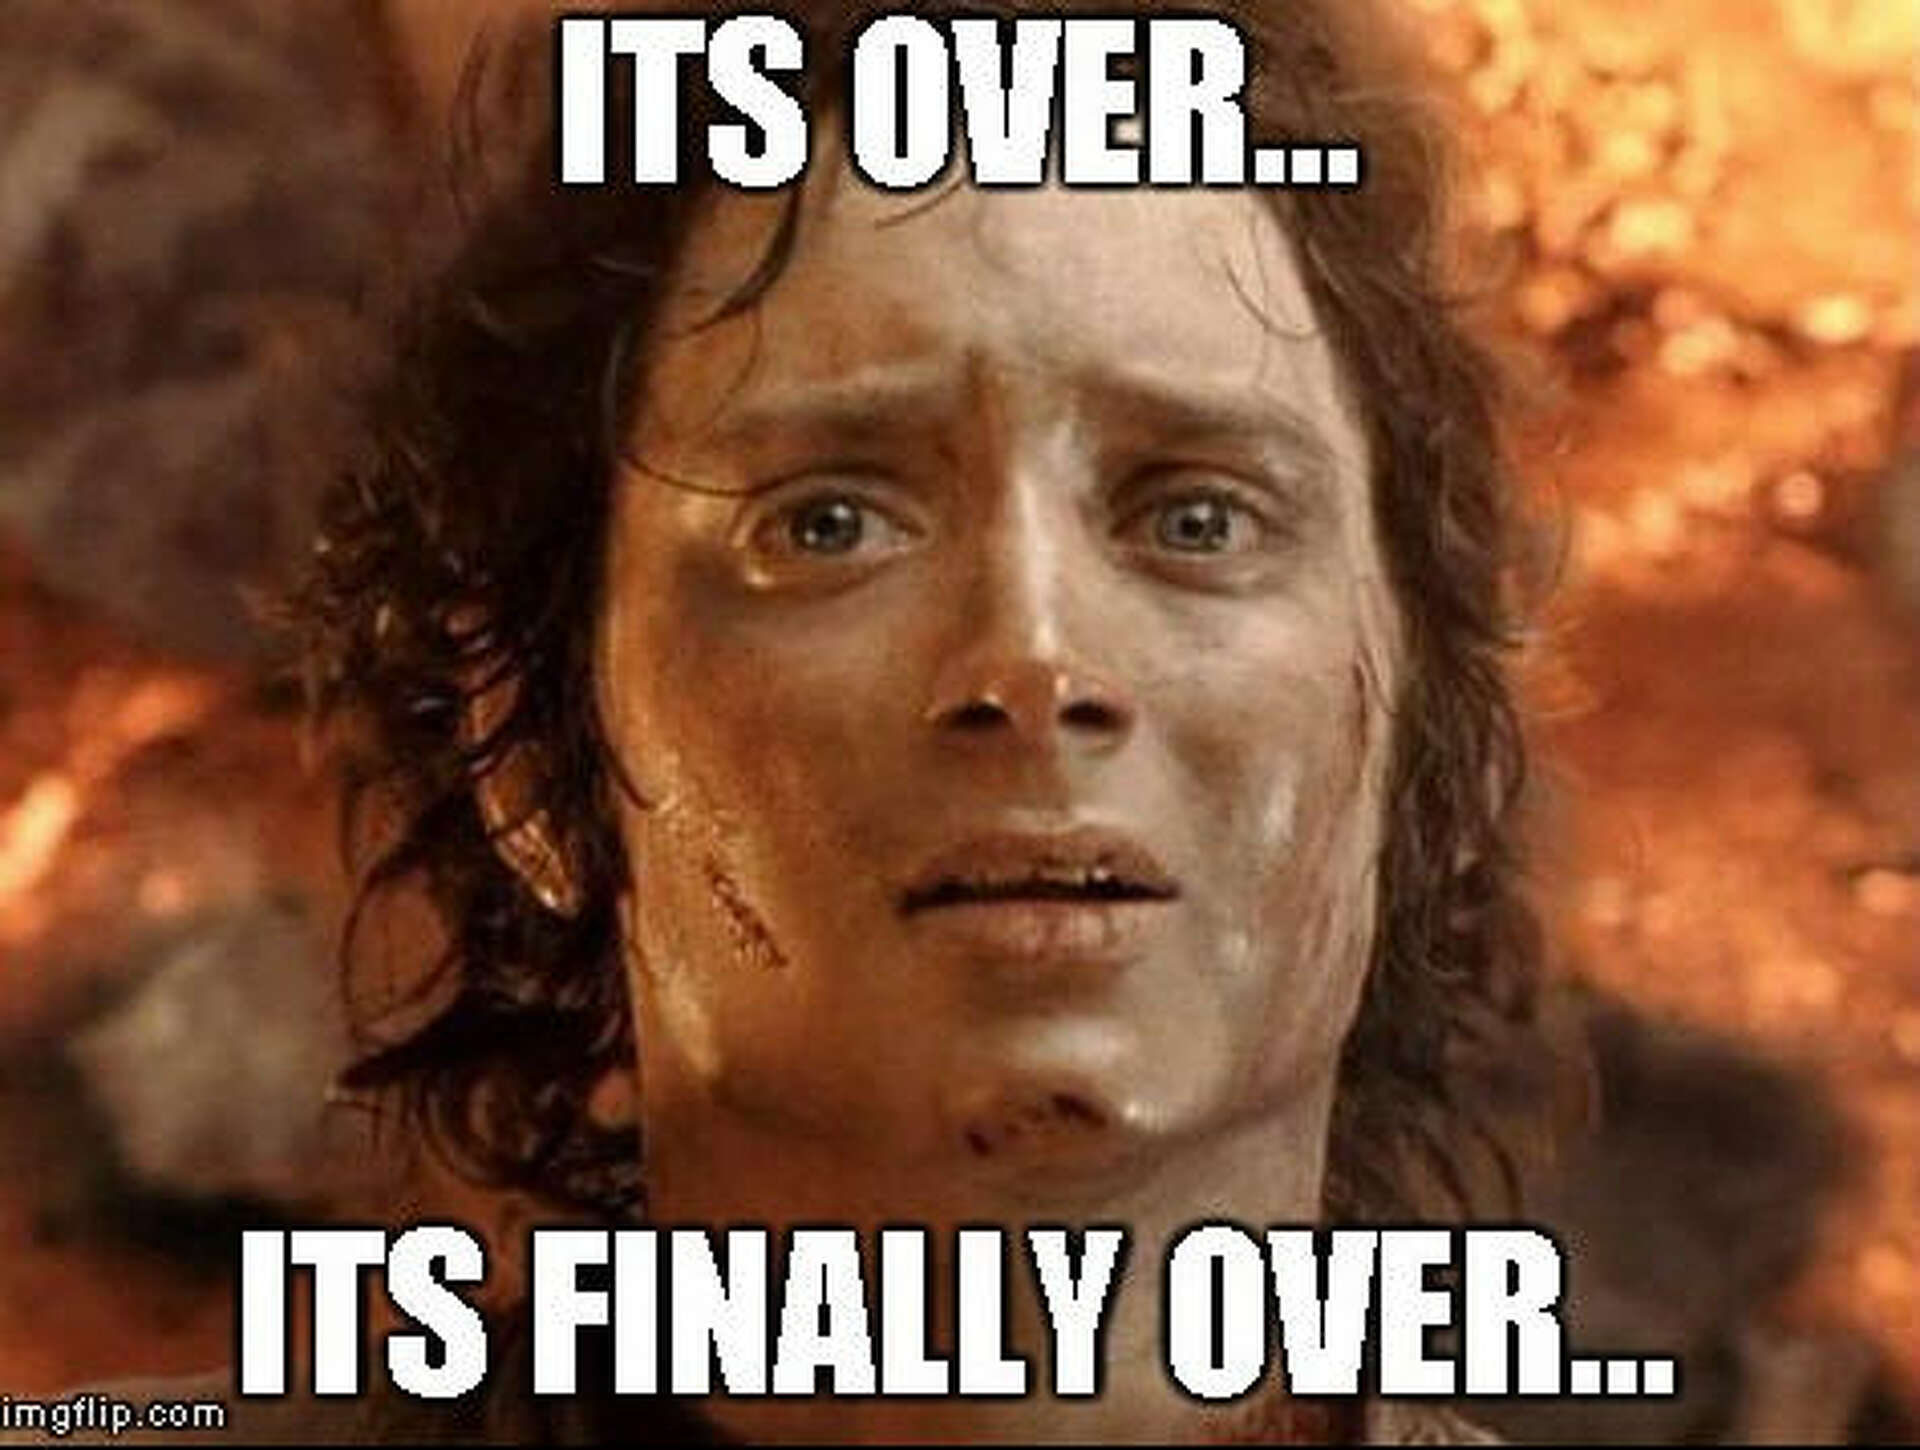